<a href="https://colab.research.google.com/github/CVanorio/EnvirSt956-UrbanHeatIslandAnalysis/blob/main/HighResolutionUHIAnalysis_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparing High Resoltuion Thermal Imagery to Landsat 8 for Urban Heat Islands**
### This code analyzes high resolution thermal imagery to assess urban heat island characteristics and compares the results to Landsat 8 thermal imagery. The aerial thermal imagery used in this analysis was acquired by the [Wisconsin DNR](https://data-wi-dnr.opendata.arcgis.com/search?q=temperature) in July of 2022 and has a resolution of 10 meters.

####**Pre-requesites for this project include:**


*   Your high resolution thermal data uploaded to your Google Drive account
*   A Google Earth Engine Account with a registered cloud project
*   Your urban or boundary shapefile
*   Data for this example can be found at [this repository](https://github.com/CVanorio/EnvirSt956-UrbanHeatIslandAnalysis)



## 1. Connect to your Google Drive and Google Earth Engine Account

In [1]:
# the following two lines establishes the connection
# to your google drive and "mounts" your drive as gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Import the Earth Engine Python API
import ee
# Authenticate the user with Earth Engine
ee.Authenticate()
# Initialize the Earth Engine library with a specific project
ee.Initialize(project='ee-cvanorio')

## 2. Install and import necessary modules and update all existing packages

In [3]:
# install the missing modules
!pip install rasterio
!pip install geopandas
#!add-apt-repository ppa:ubuntugis/ppa #This requires user input to finish installing
!apt install gdal-bin
!pip install geemap
!pip install ipyleaflet==0.18.2

# update all packages
!apt update

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 41.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-gdal python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 5,055 kB of archives.
After this operation, 25.1 MB of additional disk space will be used.
Get:1 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.6.4+dfsg-1~jammy0 [1,027 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.6.4+dfsg-1~jammy0 [561 kB]
39% [2 python3-numpy 14.2 kB/3,467 kB 0%]Selecting pre

In [4]:
import subprocess

# Command to add repository
command = "add-apt-repository ppa:ubuntugis/ppa"

# Run the command with automatic input of Enter
subprocess.run(['echo', '', '|', 'yes', '|'] + command.split())

CompletedProcess(args=['echo', '', '|', 'yes', '|', 'add-apt-repository', 'ppa:ubuntugis/ppa'], returncode=0)

In [5]:
# import necessary modules
from osgeo import gdal
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.mask import mask
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import mapping
import json
import geemap
import time

## 3. This project uses a city boundary shapefile. For the shapefile, be sure to include all of the supporting files such as the .cpg, .dbf, .prj, and .shx files.

In [6]:
# now copy the files of interest using linux copy
# NOTE your files will be located at a different path!
# You can rename the files by adding a new file name in quotes after the file path
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/Milwaukee_City_Boundary.cpg' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/Milwaukee_City_Boundary.dbf' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/Milwaukee_City_Boundary.prj' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/Milwaukee_City_Boundary.shp' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/Milwaukee_City_Boundary.shx' .

# List all of the files in the working directory to confirm all were copied successfully
!ls

gdrive			     Milwaukee_City_Boundary.dbf  Milwaukee_City_Boundary.shp  sample_data
Milwaukee_City_Boundary.cpg  Milwaukee_City_Boundary.prj  Milwaukee_City_Boundary.shx


## 4. Read the shapefile and create a GEE feature collection for the ROI

In [7]:
# Use geopandas to read the shapefile into a GeoDataFrame
shapefile = gpd.read_file('Milwaukee_City_Boundary.shp')
# Print the coordinate reference system (CRS) of the shapefile
print(shapefile.crs)

# if the CRS does not match, reproject the vector data using this code
#shapefile = shapefile.to_crs({'init': 'EPSG: YOUR CRS HERE'})
#print(shapefile.crs)

# # this generates a list of shapely geometries
geoms = shapefile.geometry.values

# let's grab a single shapely geometry to check
geometry = geoms[0] # grab the first one
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

# # Load the shapefile as a FeatureCollection
roiFeatureCol = ee.FeatureCollection(feature)

ee_roi = geemap.shp_to_ee("'Milwaukee_City_Boundary.shp'")

EPSG:4326
<class 'shapely.geometry.multipolygon.MultiPolygon'>
MULTIPOLYGON (((-88.0633524885247 43.1921265689311, -88.0615339232997 43.1921358990639, -88.053693204626 43.192177048578, -88.0437663099599 43.1922910865299, -88.0416008851234 43.1923143910973, -88.0346333397137 43.1923890965666, -88.0337487162212 43.1923985505009, -88.0334033095101 43.1924014239585, -88.0244771449227 43.1924753409761, -88.0237497491762 43.1924813346688, -88.013892352172 43.1925310736702, -88.0050687755812 43.1925551076397, -88.0016868862664 43.1925567489098, -87.994172007233 43.1925527374961, -87.9943471621505 43.1850786255096, -87.994478015678 43.1777736103051, -87.994615455302 43.1704862970071, -87.9947592028555 43.1631999961698, -87.9848337267348 43.1630904942516, -87.9748601223671 43.163132332253, -87.974885592753 43.1625112083992, -87.9751499625064 43.156063543723, -87.9754677976729 43.1485731387546, -87.9654761222428 43.1485838851314, -87.965449351117 43.149427300365, -87.9651986009125 43.15586823508

## 5. Get Sentinel 2 for the ROI and view the image

In [8]:
# Define function to mask clouds
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    # Both flags should be set to zero, indicating clear conditions.
    mask = (
        qa.bitwiseAnd(cloud_bit_mask)
        .eq(0)
        .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    )
    return image.updateMask(mask).divide(10000)

# Define Sentinel-2 image collection
milwaukeeS2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate("2022-05-01", "2022-08-01") \
    .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'QA60']) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',5)) \
    .filterBounds(roiFeatureCol) \
    .map(maskS2clouds)

# Print the number of images in the collection
print("Number of images in the collection:", milwaukeeS2.size().getInfo())

milwaukeeS2 = milwaukeeS2.mean()

# Clip the collection to the exact shape of the ROI
milwaukeeS2 = milwaukeeS2.clip(roiFeatureCol)

Number of images in the collection: 9


In [9]:
crs = milwaukeeS2.projection().getInfo()['crs']
print("CRS of the image:", crs)

CRS of the image: EPSG:4326


In [10]:
# Set up display environment
Map = geemap.Map()
Map.addLayerControl()

# Define visualization parameters for true color and false color
visParams = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2']
}

visParamsFalseColor = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B11', 'B8', 'B4'],
}
Map

# Add Sentinel 2 imagery to the map
Map.addLayer(milwaukeeS2, visParams, "Sentinel 2 True Color")

# Add Sentinel 2 imagery to the map with false color
Map.addLayer(milwaukeeS2, visParamsFalseColor, "Sentinel 2 False Color")

# Center the map on the ROI at zoom level 11
Map.centerObject(roiFeatureCol, 11)

# Call the map to display it
Map

Map(center=[43.06413159420459, -87.9672249167783], controls=(WidgetControl(options=['position', 'transparent_b…

## 6. Add NDVI band to image to add additional information for classifying the image

In [11]:
# Calculate NDVI
ndvi = milwaukeeS2.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Add NDVI band to the image
milwaukeeS2WithNDVI = milwaukeeS2.toFloat().addBands(ndvi)

In [12]:
# Define visualization parameters for true color and false color
NDVIVisParams = {
    'min': 0.0,
    'max': 1.0,
    'bands':['NDVI']
    }

# Add NAIP imagery to the map with false color
Map.addLayer(milwaukeeS2WithNDVI, NDVIVisParams, "Sentinel 2 NDVI")

#Center the map on the ROI at zoom level 11
Map.centerObject(roiFeatureCol, 11)

# call the map to view it
Map

Map(bottom=192835.0, center=[43.06413159420459, -87.9672249167783], controls=(WidgetControl(options=['position…

In [13]:
# # Define the export parameters
# # Export the image, specifying scale and region.

task = ee.batch.Export.image.toDrive(**{
    'image': milwaukeeS2WithNDVI,
    'description': 'milwaukeeS2WithNDVI',
    'folder':'MilwaukeeAerial',
    'scale': 10,
    'region': roiFeatureCol.geometry().bounds(),
    'maxPixels': 703451232  # Increase maxPixels value
})
task.start()


# Wait for the export task to complete
while task.active():
    print('Export task is still active...')
    time.sleep(10)

# Check if the export was successful
if task.status()['state'] == 'COMPLETED':
    print("Export completed successfully!")
else:
    print("Export failed:", task.status()['state'])
    print("Error message:", task.status()['error_message'])


Export task is still active...
Export task is still active...
Export task is still active...
Export task is still active...
Export task is still active...
Export task is still active...
Export task is still active...
Export task is still active...
Export task is still active...
Export task is still active...


KeyboardInterrupt: 

## 7. Create a land cover classification using AUTOML.

In [14]:
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/milwaukeeS2WithNDVI1.tif' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/milwaukeeS2WithNDVI2.tif' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/milwaukeeS2WithNDVI3.tif' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/milwaukeeS2WithNDVI4.tif' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/milwaukeeS2WithNDVI5.tif' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/milwaukeeS2WithNDVI6.tif' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/milwaukeeTrainingPoints.cpg' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/milwaukeeTrainingPoints.dbf' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/milwaukeeTrainingPoints.prj' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/milwaukeeTrainingPoints.shp' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/milwaukeeTrainingPoints.shx' .

!ls

gdrive			     milwaukeeS2WithNDVI1.tif  milwaukeeTrainingPoints.cpg
Milwaukee_City_Boundary.cpg  milwaukeeS2WithNDVI2.tif  milwaukeeTrainingPoints.dbf
Milwaukee_City_Boundary.dbf  milwaukeeS2WithNDVI3.tif  milwaukeeTrainingPoints.prj
Milwaukee_City_Boundary.prj  milwaukeeS2WithNDVI4.tif  milwaukeeTrainingPoints.shp
Milwaukee_City_Boundary.shp  milwaukeeS2WithNDVI5.tif  milwaukeeTrainingPoints.shx
Milwaukee_City_Boundary.shx  milwaukeeS2WithNDVI6.tif  sample_data


In [15]:
# # # Open the classified raster file and visualize it
# # with rasterio.open('milwaukeeS2WithNDVI1.tif') as src:
# #     show(src)

# make sure the shapefile and the summer image have the same CRS
ds = rasterio.open('milwaukeeS2WithNDVI1.tif')
print(ds.crs)

shapefile = gpd.read_file('milwaukeeTrainingPoints.shp')
print(shapefile.crs)

ds.close()

EPSG:4326
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


In [16]:
shapefile = shapefile.to_crs({'init': 'EPSG:4326'})
print(shapefile.crs)

+init=epsg:4326 +type=crs


In [17]:
# let's print the feature count in the training shapefile
print(len(shapefile))

# finally open the shapefile and hold it in a "geom" variable
# this generates a list of shapely geometries
geoms = shapefile.geometry.values

635


In [18]:
import rasterio
import numpy as np
from rasterio.mask import mask
from shapely.geometry import box, mapping

# create empty numpy arrays to hold the X and y variables
X = np.array([], dtype=np.int16).reshape(0, 8)  # pixels for training
y = np.array([], dtype=np.int8)  # labels for training

# List of image file paths
image_files = [
    'milwaukeeS2WithNDVI1.tif',
    'milwaukeeS2WithNDVI2.tif',
    'milwaukeeS2WithNDVI3.tif',
    'milwaukeeS2WithNDVI4.tif',
    'milwaukeeS2WithNDVI5.tif',
    'milwaukeeS2WithNDVI6.tif'
]

# Iterate over each image source
for image_path in image_files:
    with rasterio.open(image_path) as src:
        band_count = src.count
        for index, geom in enumerate(geoms):
            feature = [mapping(geom)]

            # Create a Shapely geometry representing the bounds of the image
            image_bounds = box(*src.bounds)

            # Ensure the feature is within the bounds of the image
            if image_bounds.contains(geom):
                # the mask function returns an array of the raster pixels within this feature
                out_image, out_transform = mask(src, feature, crop=True)

                # eliminate all the pixels with 0 values for all bands - AKA not actually part of the shapefile
                out_image_trimmed = out_image[:, ~np.all(out_image == 0, axis=0)]

                # eliminate all the pixels with XXX values for all bands
                # this would be done to remove missing data values (if any)
                out_image_trimmed = out_image_trimmed[:, ~np.all(out_image_trimmed == 255, axis=0)]

                # reshape the array to [pixel count, bands]
                out_image_reshaped = out_image_trimmed.reshape(-1, band_count)

                # append the labels to the y array
                y = np.append(y, [shapefile["class"][index]] * out_image_reshaped.shape[0])

                # stack the pixels onto the pixel array
                X = np.vstack((X, out_image_reshaped))

    src.close()

In [19]:
# What are our classification labels?
labels = np.unique(shapefile["class"])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size,
                                                                classes=labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

print(X)
print(y)

The training data include 4 classes: [1 2 3 4]

Our X matrix is sized: (635, 8)
Our y array is sized: (635,)
[[ 0.04725556  0.07626667  0.06531111 ...  0.14042222  0.
   0.65354234]
 [ 0.042       0.07536667  0.06137778 ...  0.13115555  0.
   0.6938934 ]
 [ 0.02897778  0.06254444  0.02686667 ...  0.08431111  0.
   0.8820545 ]
 ...
 [ 0.02033333  0.03483333  0.02203333 ...  0.0193      0.
   0.23804031]
 [ 0.01923333  0.02716667  0.01703333 ...  0.01616667  0.
  -0.00689656]
 [ 0.26086667  0.22486667  0.1348     ...  0.1882      0.
   0.06475487]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2
 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1
 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4

In [20]:
# import a library for spliting data into random train and test subsets
from sklearn.model_selection import train_test_split
# i.e. 75 % training dataset and 25 % test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
print('training X size:',X_train.shape)
print('training y size:',y_train.shape)
print('test X size:',X_test.shape)
print('test y size:',y_test.shape)

training X size: (476, 8)
training y size: (476,)
test X size: (159, 8)
test y size: (159,)


In [21]:
# first install the library on the VM
!pip install -q flaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 5.5 MB/s eta 0:00:00


In [22]:
# import the library and train
from flaml import AutoML
automl = AutoML()
automl.fit(X_train, y_train, task="classification", time_budget=60)

[flaml.automl.logger: 05-06 20:15:51] {1680} INFO - task = classification
[flaml.automl.logger: 05-06 20:15:51] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 05-06 20:15:51] {1789} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 05-06 20:15:51] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 05-06 20:15:51] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-06 20:15:54] {2345} INFO - Estimated sufficient time budget=26614s. Estimated necessary time budget=613s.
[flaml.automl.logger: 05-06 20:15:54] {2392} INFO -  at 2.8s,	estimator lgbm's best error=0.7761,	best estimator lgbm's best error=0.7761
[flaml.automl.logger: 05-06 20:15:54] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-06 20:15:54] {2392} INFO -  at 3.0s,	estimator lgbm's best error=0.7761,	best estimator lgbm's best error=0.7761
[flaml.automl.logger: 05-06 20:15:

In [23]:
# get best model
print('best model is:',automl.best_estimator)

# print the parameters of the best model
print(automl.best_config)

best model is: lgbm
{'n_estimators': 30, 'num_leaves': 4, 'min_child_samples': 3, 'learning_rate': 0.16075432906282125, 'log_max_bin': 10, 'colsample_bytree': 0.7622839098563244, 'reg_alpha': 0.004577823970660193, 'reg_lambda': 0.4809257969279843}



ACCURACY OF THE SELECTED MODEL:  0.9119496855345912


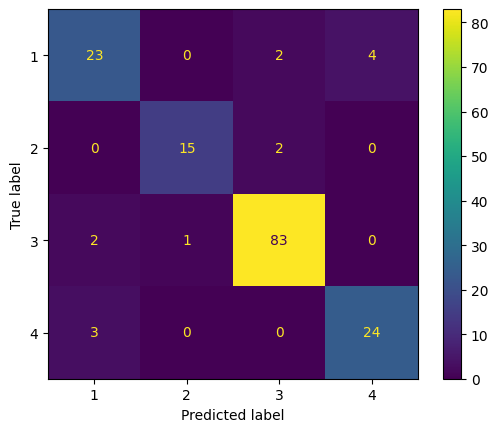

In [24]:
# make predictions
y_pred = automl.predict(X_test)

# metrics are used to find accuracy or error
from sklearn import metrics
print()

# using metrics module for accuracy calculation
print("ACCURACY OF THE SELECTED MODEL: ", metrics.accuracy_score(y_test, y_pred))

# also plot the confusion matrix to see class-specific errors
cm = metrics.confusion_matrix(y_test, y_pred, labels = automl.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = automl.classes_)
disp.plot()

## Create a moving window to classify each image individually.
#### This prevents exceeding the available RAM in Google Colab for large images.

In [25]:
patch_size = (256, 256)

def classify_image(image_path):
    # Open the image
    with rasterio.open(image_path) as ds:
        # Get image properties
        rows, cols = ds.shape
        bands = ds.count

        # Initialize an empty array for predictions
        preds = np.zeros((rows, cols), dtype=np.uint8)

        # Iterate over image patches
        for start_row in range(0, rows, patch_size[0]):

            end_row = min(start_row + patch_size[0], rows)

            for start_col in range(0, cols, patch_size[1]):

                end_col = min(start_col + patch_size[1], cols)

                height = end_row-start_row
                width = end_col-start_col
                # print(height)
                # print(width)

                # Read the patch
                w = rasterio.windows.Window(start_col, start_row, patch_size[1], patch_size[0])
                patch = ds.read(window=w)
                # print(patch.shape)

                transposedPatch = patch.transpose(1, 2, 0)
                # print(transposedPatch.shape)

                # Reshape the patch for classification
                reshapedPatch = transposedPatch.reshape(height*width, bands)

                # Classify the patch
                patch_preds = automl.predict(reshapedPatch)

                # Reshape and place the patch predictions in the output array
                # reshape the array with size of window
                patch_preds = patch_preds.reshape(height, width)
                # print(patch_preds.shape)
                # add predictions to preds array from row start to
                preds[start_row:end_row, start_col:end_col] = patch_preds

        ds.close()

    return preds

#classify each iamge
image1 = 'milwaukeeS2WithNDVI1.tif'
preds1 = classify_image(image1)
print(preds1.shape)

image2 = 'milwaukeeS2WithNDVI2.tif'
preds2 = classify_image(image2)
print(preds2.shape)

image3 = 'milwaukeeS2WithNDVI3.tif'
preds3 = classify_image(image3)
print(preds3.shape)

image4 = 'milwaukeeS2WithNDVI4.tif'
preds4 = classify_image(image4)
print(preds4.shape)

image5 = 'milwaukeeS2WithNDVI5.tif'
preds5 = classify_image(image5)
print(preds5.shape)

image6 = 'milwaukeeS2WithNDVI6.tif'
preds6 = classify_image(image6)
print(preds6.shape)

(11776, 11776)
(11776, 11291)
(11776, 11776)
(11776, 11291)
(6944, 11776)
(6944, 11291)


In [26]:
def export_image(preds, input_image_path, output_image_path):
    # Open the classified image and get shape
    ds = gdal.Open(input_image_path, gdal.GA_ReadOnly)
    im = ds.GetRasterBand(1).ReadAsArray()  # read the first band
    [cols, rows] = im.shape

    # Use the GeoTiff driver
    driver = gdal.GetDriverByName("GTiff")
    # Create an output file data object
    outdata = driver.Create(output_image_path, rows, cols, 1, gdal.GDT_Byte, ['COMPRESS=LZW'])
    outdata.SetGeoTransform(ds.GetGeoTransform())  # sets same geotransform as input
    outdata.SetProjection(ds.GetProjection())  # sets same projection as input
    outdata.GetRasterBand(1).WriteArray(preds)  # this is where you actually write the image to the file on disk
    outdata.GetRasterBand(1).SetNoDataValue(0)  # if you want these values transparent
    outdata.FlushCache()  # saves to disk!!
    outdata = None  # closes the file

export_image(preds1, 'milwaukeeS2WithNDVI1.tif', 'milwaukeeClassification1.tif')
export_image(preds2, 'milwaukeeS2WithNDVI2.tif', 'milwaukeeClassification2.tif')
export_image(preds3, 'milwaukeeS2WithNDVI3.tif', 'milwaukeeClassification3.tif')
export_image(preds4, 'milwaukeeS2WithNDVI4.tif', 'milwaukeeClassification4.tif')
export_image(preds5, 'milwaukeeS2WithNDVI5.tif', 'milwaukeeClassification5.tif')
export_image(preds6, 'milwaukeeS2WithNDVI6.tif', 'milwaukeeClassification6.tif')

!ls

gdrive			      milwaukeeClassification3.tif  milwaukeeS2WithNDVI5.tif
Milwaukee_City_Boundary.cpg   milwaukeeClassification4.tif  milwaukeeS2WithNDVI6.tif
Milwaukee_City_Boundary.dbf   milwaukeeClassification5.tif  milwaukeeTrainingPoints.cpg
Milwaukee_City_Boundary.prj   milwaukeeClassification6.tif  milwaukeeTrainingPoints.dbf
Milwaukee_City_Boundary.shp   milwaukeeS2WithNDVI1.tif	    milwaukeeTrainingPoints.prj
Milwaukee_City_Boundary.shx   milwaukeeS2WithNDVI2.tif	    milwaukeeTrainingPoints.shp
milwaukeeClassification1.tif  milwaukeeS2WithNDVI3.tif	    milwaukeeTrainingPoints.shx
milwaukeeClassification2.tif  milwaukeeS2WithNDVI4.tif	    sample_data


### **After downloading, upload the images to GEE**

In [27]:
# export the images to your Google Drive
from google.colab import files

files.download('milwaukeeClassification1.tif')
files.download('milwaukeeClassification2.tif')
files.download('milwaukeeClassification3.tif')
files.download('milwaukeeClassification4.tif')
files.download('milwaukeeClassification5.tif')
files.download('milwaukeeClassification6.tif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### View the images

In [28]:
# open the thermal images as GEE Images using the asset IDs
# change the path to your asset ID from the share asset link in GEE

milwaukeeClassification1 = ee.Image("projects/ee-cvanorio/assets/milwaukeeClassification1")
milwaukeeClassification2 = ee.Image("projects/ee-cvanorio/assets/milwaukeeClassification2")
milwaukeeClassification3 = ee.Image("projects/ee-cvanorio/assets/milwaukeeClassification3")
milwaukeeClassification4 = ee.Image("projects/ee-cvanorio/assets/milwaukeeClassification4")
milwaukeeClassification5 = ee.Image("projects/ee-cvanorio/assets/milwaukeeClassification5")
milwaukeeClassification6 = ee.Image("projects/ee-cvanorio/assets/milwaukeeClassification6")

In [29]:
# Create an image collection from the individual images
image_collection = ee.ImageCollection([milwaukeeClassification1,
                                       milwaukeeClassification2,
                                        milwaukeeClassification3,
                                        milwaukeeClassification4,
                                        milwaukeeClassification5,
                                        milwaukeeClassification6])

# # Mosaic the images
classMosaic = image_collection.mosaic().clip(roiFeatureCol)

# Classes
# '0': 'Outside of ROI',
# '1': 'Grass',
# '2': 'Water',
# '3': 'Impervious',
# '4': 'Trees'


# Display the class mosaic on the map with the legend
Map.addLayer(classMosaic, {'min': 1, 'max': 4, 'palette': ['yellow', 'blue', 'red', 'green']}, 'Classification')
Map.centerObject(roiFeatureCol, 11)  # Center the map on the mosaic image with zoom level 10
Map

Map(bottom=385651.0, center=[43.06413159420459, -87.9672249167783], controls=(WidgetControl(options=['position…

## 8. Upload thermal imagery to GEE and view them.
### This code can be adjusted to use more or fewer images.

## **Go to your [GEE account](https://code.earthengine.google.com/) and upload your thermal images as assets.**
### There is no way to upload local files as assets in GEE from python.


In [30]:
# open the thermal images as GEE Images using the asset IDs
# change the path to your asset ID from the share asset link in GEE

morningTemp = ee.Image("projects/ee-cvanorio/assets/Milwaukee2022SummerMorningAirTemperatureDegreesF")

afternoonTemp = ee.Image("projects/ee-cvanorio/assets/Milwaukee2022SummerAfternoonAirTemperatureDegreesF")

eveningTemp = ee.Image("projects/ee-cvanorio/assets/Milwaukee2022SummerEveningAirTemperatureDegreesF")

In [31]:
# Add thermal images as layers to the map

Map.addLayer(morningTemp, {'bands':["b1"], 'min': 68, 'max': 75, 'palette': [
    '0502b8', '0502ce', '0502e6',
    '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
    '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
    'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
    'ff0000', 'de0101', 'c21301', 'a71001', '911003'
]}, 'Morning Air Temp')

Map.addLayer(afternoonTemp, {'bands':["b1"], 'min': 85, 'max': 95, 'palette': [
    '0502b8', '0502ce', '0502e6',
    '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
    '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
    'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
    'ff0000', 'de0101', 'c21301', 'a71001', '911003'
]}, 'Afternoon Air Temp')

Map.addLayer(eveningTemp, {'bands':["b1"], 'min': 75, 'max': 90, 'palette': [
    '0502b8', '0502ce', '0502e6',
    '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
    '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
    'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
    'ff0000', 'de0101', 'c21301', 'a71001', '911003'
]}, 'Evening Air Temp')


#Center the map on the ROI at zoom level 11
Map.centerObject(roiFeatureCol, 11)
# Display the map
Map

Map(bottom=385323.0, center=[43.06413159420459, -87.9672249167783], controls=(WidgetControl(options=['position…

## 9. Create an average thermal image.

In [32]:
# Stack the three raster images into one multi-band image
stacked = ee.ImageCollection([morningTemp, afternoonTemp, eveningTemp]).toBands()

# Calculate the average temperature
averageTemp = stacked.reduce(ee.Reducer.mean())

# Clip the average temperature to the region of interest (roi)
averageTemp = ee.Image(averageTemp)

# Rename the band
averageTemp = averageTemp.rename('b1')

# Add the layer to the map
Map.addLayer(averageTemp, {'min': 80, 'max': 86, 'palette': [
    '0502b8', '0502ce', '0502e6',
    '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
    '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
    'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
    'ff0000', 'de0101', 'c21301', 'a71001', '911003'
]}, 'Average Air Temp')


#Center the map on the ROI at zoom level 11
Map.centerObject(roiFeatureCol, 11)
# Display the map
Map

Map(bottom=192840.0, center=[43.06413159420459, -87.9672249167783], controls=(WidgetControl(options=['position…

## 10. Get Landsat 8 thermal imagery for your ROI.

In [33]:
# Define cloud mask function
def maskL8sr(image):
    # Bits 3 and 5 are cloud shadow and cloud, respectively.
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    # Get the pixel QA band.
    qa = image.select('QA_PIXEL')
    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
             .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask)

In [34]:
# Load the collection
landsatCol = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .map(maskL8sr) \
    .filterDate('2022-06-01','2022-08-01') \
    .filterBounds(roiFeatureCol)

# Reduce to median image
image = landsatCol.median()

In [35]:
# Calculate NDVI
ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

# Select thermal band 10 and convert to brightness temperature
thermal = image.select('ST_B10').multiply(0.00341802).add(149)

In [36]:
# Find the min and max of NDVI
min_ndvi = ndvi.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=roiFeatureCol,
    scale=30,
    maxPixels=1e9
).get('NDVI')

min_ndvi = ee.Number(min_ndvi)

max_ndvi = ndvi.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=roiFeatureCol,
    scale=30,
    maxPixels=1e9
).get('NDVI')

max_ndvi = ee.Number(max_ndvi)

In [37]:
# Calculate fractional vegetation
fv = ndvi.subtract(min_ndvi).divide(max_ndvi.subtract(min_ndvi)).pow(ee.Number(2)).rename('FV')

# Calculate emissivity
a = ee.Number(0.004)
b = ee.Number(0.986)
EM = fv.multiply(a).add(b).rename('EMM')

In [38]:
# Calculate Land Surface Temperature (LST) in degrees Fahrenheit
LST = thermal.expression(
    '((Tb/(1 + (0.00115* (Tb / 1.438))*log(Ep)))-273.15)*(9/5)+32', {
     'Tb': thermal.select('ST_B10'),
    'Ep': EM.select('EMM')
  }).rename('b1')

In [39]:
# Clip LST to region of interest
LST = LST.clip(roiFeatureCol)

# Convert the image data type from double to float
LST = LST.toFloat()

# Visualize LST
LST_vis_params = {'min': 70, 'max': 100, 'palette': [
    '0502b8', '0502ce', '0502e6',
    '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
    '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
    'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
    'ff0000', 'de0101', 'c21301', 'a71001', '911003'
]}

Map.addLayer(LST, LST_vis_params, 'Landsat LST')
Map

Map(bottom=192849.0, center=[43.05032512283074, -87.97336578369142], controls=(WidgetControl(options=['positio…

In [40]:
# # Define the export parameters
# # Export the image, specifying scale and region.

task = ee.batch.Export.image.toDrive(**{
    'image': LST,
    'description': 'milwaukeeLandsatLST',
    'folder':'MilwaukeeAerial',
    'scale': 100,
    'region': roiFeatureCol.geometry().bounds(),
    'maxPixels': 703451232  # Increase maxPixels value
})
task.start()


# Wait for the export task to complete
while task.active():
    print('Export task is still active...')
    time.sleep(10)

# Check if the export was successful
if task.status()['state'] == 'COMPLETED':
    print("Export completed successfully!")
else:
    print("Export failed:", task.status()['state'])
    print("Error message:", task.status()['error_message'])

Export task is still active...
Export task is still active...
Export completed successfully!


# 11. Analyze spatial statistics

In [41]:
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/Milwaukee2022SummerAfternoonAirTemp.tiff' 'afternoonTemp.tif'
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/Milwaukee2022SummerEveningAirTemp.tiff' 'eveningTemp.tif'
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/Milwaukee2022SummerMorningAirTemp.tiff' 'morningTemp.tif'
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/milwaukeeLandsatLST.tif' 'landsatLST.tif'

!cp '/content/gdrive/MyDrive/MilwaukeeAerial/Classified/milwaukeeClassification1.tif' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/Classified/milwaukeeClassification2.tif' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/Classified/milwaukeeClassification3.tif' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/Classified/milwaukeeClassification4.tif' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/Classified/milwaukeeClassification5.tif' .
!cp '/content/gdrive/MyDrive/MilwaukeeAerial/Classified/milwaukeeClassification6.tif' .

!ls

afternoonTemp.tif	      milwaukeeClassification2.tif  milwaukeeS2WithNDVI6.tif
eveningTemp.tif		      milwaukeeClassification3.tif  milwaukeeTrainingPoints.cpg
gdrive			      milwaukeeClassification4.tif  milwaukeeTrainingPoints.dbf
landsatLST.tif		      milwaukeeClassification5.tif  milwaukeeTrainingPoints.prj
Milwaukee_City_Boundary.cpg   milwaukeeClassification6.tif  milwaukeeTrainingPoints.shp
Milwaukee_City_Boundary.dbf   milwaukeeS2WithNDVI1.tif	    milwaukeeTrainingPoints.shx
Milwaukee_City_Boundary.prj   milwaukeeS2WithNDVI2.tif	    morningTemp.tif
Milwaukee_City_Boundary.shp   milwaukeeS2WithNDVI3.tif	    sample_data
Milwaukee_City_Boundary.shx   milwaukeeS2WithNDVI4.tif
milwaukeeClassification1.tif  milwaukeeS2WithNDVI5.tif


## Diurnal Temperature Range

[[-3.4e+38 -3.4e+38 -3.4e+38 ... -3.4e+38 -3.4e+38 -3.4e+38]
 [-3.4e+38 -3.4e+38 -3.4e+38 ... -3.4e+38 -3.4e+38 -3.4e+38]
 [-3.4e+38 -3.4e+38 -3.4e+38 ... -3.4e+38 -3.4e+38 -3.4e+38]
 ...
 [-3.4e+38 -3.4e+38 -3.4e+38 ... -3.4e+38 -3.4e+38 -3.4e+38]
 [-3.4e+38 -3.4e+38 -3.4e+38 ... -3.4e+38 -3.4e+38 -3.4e+38]
 [-3.4e+38 -3.4e+38 -3.4e+38 ... -3.4e+38 -3.4e+38 -3.4e+38]]


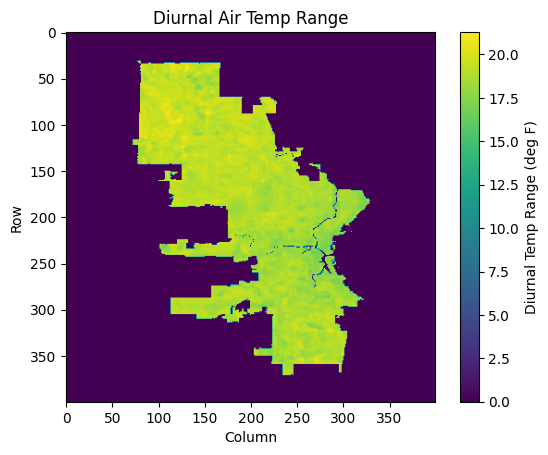

In [42]:
########## DIURNAL TEMP RANGE

thermalImages = ['morningTemp.tif', 'afternoonTemp.tif', 'eveningTemp.tif']

# Open first GeoTIFF image
image = rasterio.open(thermalImages[0])

# Get image dimensions
rows, cols = image.shape

minValues = image.read(1)

print(minValues)

maxValues = np.copy(minValues)

image.close()

for i in range(1, len(thermalImages)):

    image = rasterio.open(thermalImages[i])

    # Loop through each pixel
    for row in range(rows):
        for col in range(cols):
            # Get temperature values at the current pixel from all three images
            currPixelTemp = image.read(1, window=((row, row+1), (col, col+1)))[0][0]

            # Update minimum and maximum values for the current pixel
            currMin = minValues[row, col]
            currMax = maxValues[row, col]
            minValues[row, col] = min(currMin, currPixelTemp)
            maxValues[row, col] = max(currMax, currPixelTemp)

    image.close()


# Subtract the min value array from the max value array
diurnalRange = maxValues - minValues

# Display the difference array
plt.imshow(diurnalRange, cmap='viridis')  # Choose a colormap
plt.colorbar(label='Diurnal Temp Range (deg F)')
plt.title('Diurnal Air Temp Range')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()




In [43]:
export_image(diurnalRange, 'morningTemp.tif', 'milwaukeeDiurnalRange.tif')

# export the images to your Google Drive
from google.colab import files

files.download('milwaukeeDiurnalRange.tif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
diurnalRange = ee.Image("projects/ee-cvanorio/assets/milwaukeeDiurnalRange")
# Clip LST to region of interest
diurnalRange = diurnalRange.clip(roiFeatureCol)

# Get the min and max values of the image
min_max_values = diurnalRange.reduceRegion(reducer=ee.Reducer.minMax(), geometry=roiFeatureCol, scale=10)

# Extract min and max values from the dictionary
min_value = min_max_values.get('b1_min')  # Replace 'image_band_name' with the actual band name
max_value = min_max_values.get('b1_max')  # Replace 'image_band_name' with the actual band name

# Define visualization parameters
vis_params = {
    'min': min_value.getInfo(),
    'max': max_value.getInfo(),
    'palette': [
    '0502b8', '0502ce', '0502e6',
    '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
    '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
    'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
    'ff0000', 'de0101', 'c21301', 'a71001', '911003'
]}

# Visualize the image
Map.addLayer(diurnalRange, vis_params, 'Diurnal Temp Range')
Map.centerObject(diurnalRange, 11)
Map

Map(bottom=192834.0, center=[43.0579715742369, -87.96704999311083], controls=(WidgetControl(options=['position…

## Average Temperature by Class

In [45]:
##### Temp by class

# Define the class value you want to keep
class_values = [1, 2, 3, 4]  # Change this to your desired class value

# Create an empty image collection to store the masked images
masked_images = ee.ImageCollection([])

# Loop over the class values
for class_value in class_values:
    # Create a mask based on the specified class value
    mask = classMosaic.eq(class_value)

    # Apply the mask to the image
    masked_image = classMosaic.updateMask(mask)

    # Add the masked image to the image collection
    masked_images = masked_images.merge(masked_image)


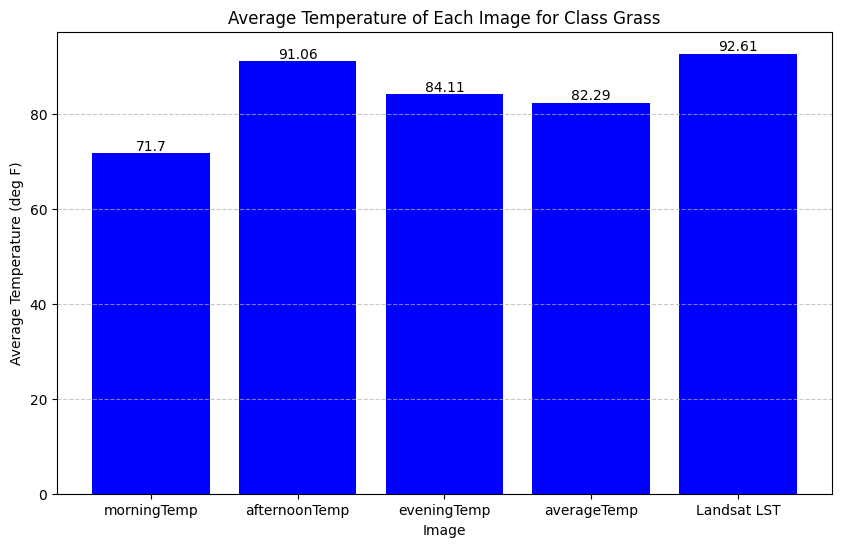

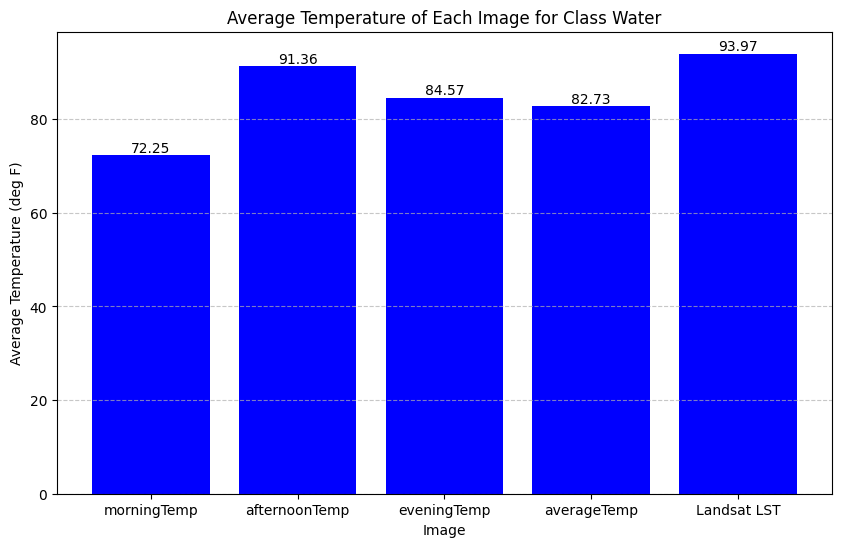

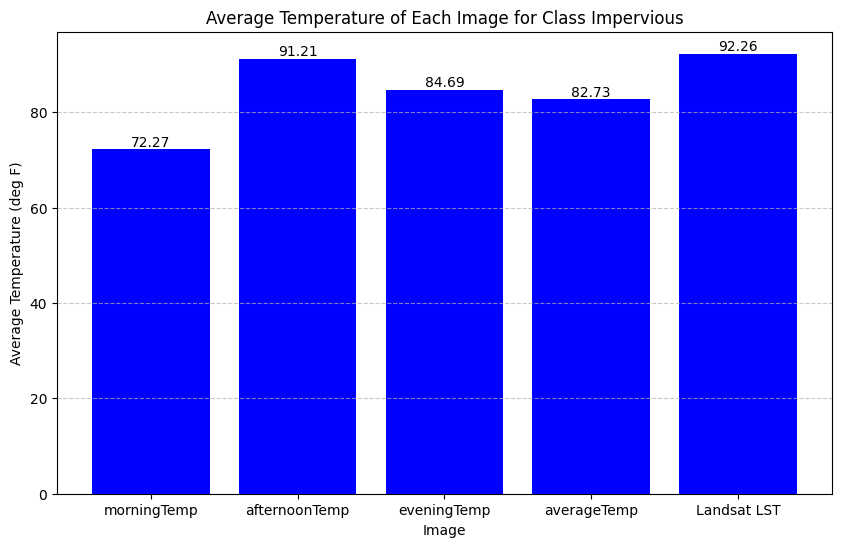

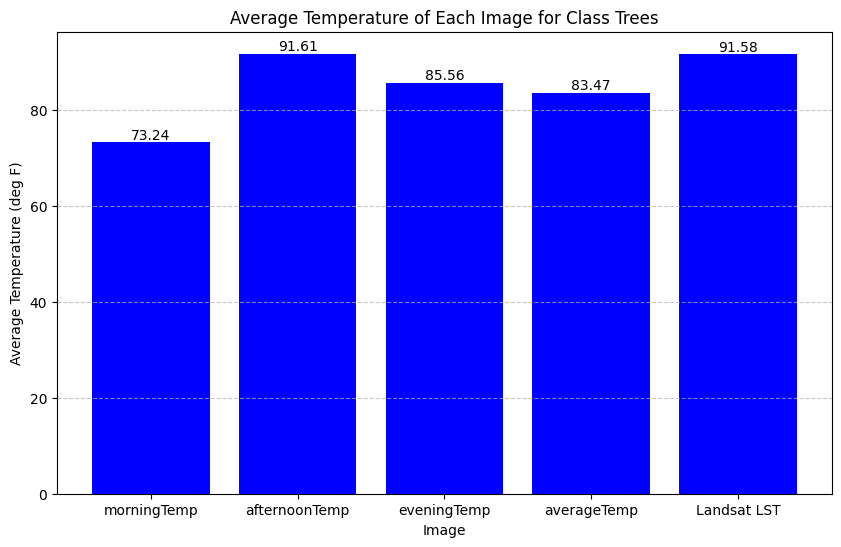

In [46]:
########## AVG TEMP BY LAND COVER

# Define the image IDs of the classification images
classificationCol = masked_images

# Define the image IDs of the temperature images
temperature_images = [morningTemp, afternoonTemp, eveningTemp, averageTemp, LST]

# Define the number of classes
num_classes = 4

classLabels = ['Grass', 'Water', 'Impervious', 'Trees']

# Define the scale
scale = 10  # Choose an appropriate scale

# Initialize a list to store the average temperature for each class
average_temperatures_by_class = []

# Loop through each classification image in the collection
# Iterate through each image in the collection
for currClass in range(num_classes):
    # Get the image at index i
    singleClassImage = ee.Image(image_collection.toList(num_classes).get(currClass))

    average_temperatures_by_image = []

    # Iterate over each temperature image in the list
    for temperature_image in temperature_images:

        # Mask out the temperature values using the classification image for the current class
        masked_temperature = temperature_image.updateMask(singleClassImage)

        # Reduce the mean temperature within the class to get the average temperature
        classAvgTemp = masked_temperature.reduceRegion(
            reducer=ee.Reducer.mean(),  # Compute the mean temperature
            geometry=singleClassImage.geometry(),  # Optionally, specify a region of interest
            scale=scale,  # Specify the scale
            bestEffort=True,  # Use multiple pixels to estimate the mean if needed
        )

        # Append the average temperature to the list
        average_temperatures_by_image.append(classAvgTemp.get('b1').getInfo())

    # Append the average temperature to the list
    average_temperatures_by_class.append(average_temperatures_by_image)

    # Plot the bar chart for the current class
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(temperature_images)), average_temperatures_by_image, color='blue')
    plt.xlabel('Image')
    plt.ylabel('Average Temperature (deg F)')
    plt.title(f'Average Temperature of Each Image for Class {classLabels[currClass]}')

    x_values = [0, 1, 2, 3, 4]
    labels = ['morningTemp', 'afternoonTemp', 'eveningTemp', 'averageTemp', 'Landsat LST']
    plt.xticks(x_values, labels)

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add bar values over each bar
    for bar, value in zip(bars, average_temperatures_by_image):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 2),
                 ha='center', va='bottom')
    plt.show()



In [47]:
## Check acquisition time for the landsat imagery

import pytz
from datetime import datetime

# Get the first image in the collection
firstLandsatImage = ee.Image(landsatCol.first())

# Get the acquisition time of the first image (in milliseconds)
acquisition_time_ms = firstLandsatImage.get('system:time_start').getInfo()

# Convert milliseconds to a Python datetime object
acquisition_datetime_utc = datetime.utcfromtimestamp(acquisition_time_ms / 1000)

# Define the UTC timezone
utc_timezone = pytz.timezone('UTC')

# Localize the acquisition datetime to the UTC timezone
acquisition_datetime_utc = utc_timezone.localize(acquisition_datetime_utc)

# Define the US Central Time (CST) timezone
cst_timezone = pytz.timezone('America/Chicago')

# Convert the acquisition datetime from UTC to US Central Time (CST)
acquisition_datetime_cst = acquisition_datetime_utc.astimezone(cst_timezone)

# Print the acquisition time in US Central Time (CST)
print("Acquisition Time (CST):", acquisition_datetime_cst)

Acquisition Time (CST): 2022-06-09 11:34:48.722000-05:00


\
\
\
\
\
\
\
\
\
\
\



1.   make image stack of all data -> convert to csv?
4.   get hot spots of all thermal -> stack and display 2 bands?
6.   see how correlated each image is to land cover



In [ ]:
########## HOTSPOT

from skimage import filters

# Open the GeoTIFF image
with rasterio.open('morning.tif') as src:
    # Read the image as a numpy array
    image = src.read()

    src.close()

# Flatten the image to a 1D array
flat_image = image.flatten()

# Calculate local standard deviation using a filter (e.g., gaussian filter)
# You can choose other filters or methods depending on your requirements
local_std = filters.gaussian(flat_image, sigma=5)

# Reshape the result to the original image shape
local_std = local_std.reshape(image.shape)

# Define a threshold for hot spots
threshold = 2.0  # Adjust as needed

# Find hot spots (areas with high local standard deviation)
hot_spots = local_std > threshold

# Optionally, you can save the hot spot mask to a new GeoTIFF file
with rasterio.open('hot_spots.tif', 'w', **src.profile) as dst:
    dst.write(hot_spots.astype(np.uint8), 1)

# Optionally, you can visualize the hot spots using matplotlib or other plotting libraries
import matplotlib.pyplot as plt

plt.imshow(hot_spots, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
########## CORRELATION

In [ ]:
# Install necessary packages
!apt-get install python-gdal
!pip install rasterio

In [ ]:
!ls

In [ ]:
# Import libraries
import numpy as np
import rasterio
from scipy.stats import gaussian_kde
from rasterio.mask import mask as rio_mask

imageList = ['morningTemp.tif', 'afternoonTemp.tif', 'eveningTemp.tif', 'landsatLST.tif']

shapefile_path = 'Milwaukee_City_Boundary.shp'

# Read the shapefile
roi = gpd.read_file(shapefile_path)

for image in imageList:
# Read TIF image
    tif_path = image
    with rasterio.open(tif_path) as src:
        data, transform = rio_mask(src, roi.geometry, crop=True)
        data = data[0]  # Extract the masked data
        shape = data.shape

    src.close()
    shape = data.shape
    print(shape)
    print(image.shape)
    # Flatten the data
    flat_data = data.flatten()

    # Perform Getis-Ord analysis
    z_scores = gaussian_kde(flat_data).evaluate(flat_data)

    # Reshape Z scores back to the original shape
    z_scores = z_scores.reshape(shape)

    # Plot the results
    plt.figure(figsize=(10, 8))
    plt.imshow(z_scores, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Getis-Ord Z Score')
    plt.title(f'Getis-Ord Analysis Results for {tif_path}')
    plt.show()

    # # # plt.hist(z_scores, bins=50)
    # # # plt.xlabel('Z Score')
    # # # plt.ylabel('Frequency')
    # # # plt.title(f'Histogram of Getis-Ord Z Scores for {tif_path}')
    # # # plt.show()



Mosaic the classification images

In [ ]:
from rasterio.enums import Resampling
from rasterio.merge import merge
from rasterio.plot import show

# Open the six images
image_files = ['milwaukeeClassification1.tif',
               'milwaukeeClassification2.tif',
               'milwaukeeClassification3.tif',
               'milwaukeeClassification4.tif',
               'milwaukeeClassification5.tif',
               'milwaukeeClassification6.tif']

src_files_to_mosaic = []

for file in image_files:
    src = rasterio.open(file)
    src_files_to_mosaic.append(src)

# Mosaic the images
classMosaic, out_trans = merge(src_files_to_mosaic)

src.close()

# Display the mosaic
#show(mosaic, cmap='gray')

# Assuming your 3D array
num_bands, x_size, y_size = classMosaic.shape

# Transpose the flattened image data
#transposed_image = classMosaic.transpose(1, 2, 0)

# Reshape the array to 2D
flattened_image = np.reshape(classMosaic, (num_bands, x_size * y_size))

print(flattened_image.size)
################################
from PIL import Image

# Open the image
image = Image.open('morningTemp.tif')

# Get the dimensions of the image
width, height = image.size

# Calculate the number of pixels
num_pixels = width * height

print("Number of pixels in the image:", num_pixels)
image.close()
##################################################################
export_image(flattened_image, 'morningTemp.tif', 'milwaukeeClassficationMosaic.tif')

# # export the images to your Google Drive
files.download('milwaukeeClassficationMosaic.tif')

In [ ]:
from PIL import Image
import csv

# Open the six images
images = [
    Image.open("morningTemp.tif"),
    Image.open("afternoonTemp.tif"),
    Image.open("eveningTemp.tif"),
    Image.open("landsatLST.tif"),
    Image.open(classMosaic)
]

# Get the dimensions of the images
image_width, image_height = images[0].size

# Create a CSV file and write the header
with open("milwaukee_image_data.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)

    # Write header row
    header = ['Pixel_X', 'Pixel_Y', 'morningTemp', 'afternoonTemp', 'eveningTemp', 'landsatLST', 'LCclass']
    writer.writerow(header)

    # Iterate through each pixel of the images and write to CSV
    for y in range(image_height):
        for x in range(image_width):
            pixel_data = [x, y]
            for image in images:
                pixel_value = image.getpixel((x, y))
                pixel_data.append(pixel_value)
            writer.writerow(pixel_data)

print("CSV file generated successfully.")
!ls